In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Download training data
train_data = torchvision.datasets.CIFAR10(root = '.',
                                          download = True,
                                          train = True,
                                          transform = transforms.ToTensor()   
                                         )

Files already downloaded and verified


In [3]:
test_data = torchvision.datasets.CIFAR10(root = '.',
                                         download = True,
                                         train = False,
                                         transform = transforms.ToTensor()
                                        )

Files already downloaded and verified


In [28]:
train_data.data[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [4]:
train_data.data.shape

(50000, 32, 32, 3)

In [5]:
# Number of classes
K = len(set(train_data.targets))
K

10

In [6]:
test_data.data.shape

(10000, 32, 32, 3)

In [7]:
# Data Loader

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True
                                          )

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = False
                                         )

In [8]:
for inputs, targets in train_loader:
    break

In [9]:
inputs.shape

torch.Size([128, 3, 32, 32])

In [11]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride =2),
            nn.ReLU()
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(p = 0.2),
            nn.Linear(in_features = 128*3*3, out_features = 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(in_features = 1024, out_features = K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.shape[0], -1)
        out = self.dense_layers(out)
        return out

In [12]:
# Instantiate model
model = CNN(K)

In [13]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# Define a loop function 
def batch_gd(train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    # Traning loop
    for i in range(epochs):
        train_loss = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
        train_loss = np.mean(train_loss)
        train_losses[i] = train_loss
      
        test_loss = []
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        test_losses[i] = test_loss
        
        print(f'Epoch: {i+1}/{epochs}, train_loss: {train_loss: .3f}, test_loss:{test_loss: .3f}')
    return train_losses, test_losses

In [15]:
epochs = 15

train_losses, test_losses = batch_gd(train_loader, test_loader, criterion, optimizer, epochs)

Epoch: 1/15, train_loss:  1.649, test_loss: 1.389
Epoch: 2/15, train_loss:  1.316, test_loss: 1.234
Epoch: 3/15, train_loss:  1.172, test_loss: 1.153
Epoch: 4/15, train_loss:  1.074, test_loss: 1.135
Epoch: 5/15, train_loss:  0.986, test_loss: 1.058
Epoch: 6/15, train_loss:  0.917, test_loss: 1.011
Epoch: 7/15, train_loss:  0.847, test_loss: 1.011
Epoch: 8/15, train_loss:  0.783, test_loss: 0.989
Epoch: 9/15, train_loss:  0.724, test_loss: 0.984
Epoch: 10/15, train_loss:  0.660, test_loss: 0.992
Epoch: 11/15, train_loss:  0.604, test_loss: 0.991
Epoch: 12/15, train_loss:  0.560, test_loss: 1.029
Epoch: 13/15, train_loss:  0.504, test_loss: 1.040
Epoch: 14/15, train_loss:  0.455, test_loss: 1.088
Epoch: 15/15, train_loss:  0.415, test_loss: 1.108


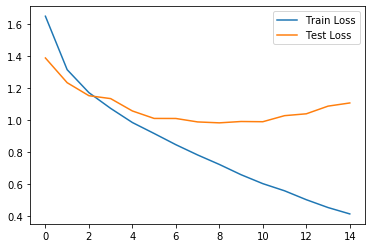

In [16]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.show()

In [17]:
# Accuracy

n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum()
    n_correct += correct.item()
    
    n_total += len(targets)
    
train_accuracy = n_correct/n_total
print('train_accuracy: %s' % (train_accuracy))

for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    correct = (predictions == targets).sum()
    n_correct += correct.item()
    n_total += len(targets)
    
test_accuracy = n_correct/n_total

print('test_accuracy: %s' % (test_accuracy))

train_accuracy: 0.8765
test_accuracy: 0.8414166666666667


In [18]:
from sklearn.metrics import confusion_matrix
import itertools

x_test = test_data.data
y_test = test_data.targets
p_test = np.array([])

for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.numpy()))


In [19]:
# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False, cmap = plt.cm.Blues, title = 'Confusion matirx'):
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, format(cm[i, j], fmt), color = 'orange' if cm[i, j] > thresh else 'black',
                 horizontalalignment = 'center')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Prediction label')
    plt.show()

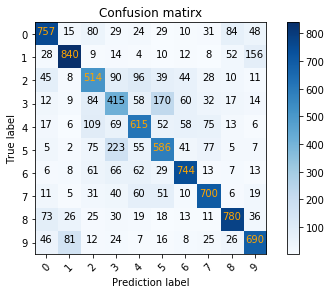

In [20]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [21]:
# label mapping
labels = '''airplane
    automobile
    bird
    cat
    deer
    dog
    frog
    horse
    ship
    truck'''.split()

1441
actual label: deer
predicted label: frog


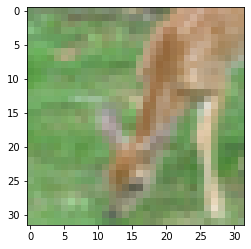

In [22]:
# show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_id = np.where(p_test != y_test)[0]
im_id = np.random.choice(misclassified_id)
print(im_id)
plt.imshow(x_test[im_id].reshape(32, 32, 3))
print('actual label: %s' % (labels[y_test[im_id]]))
print('predicted label: %s' % (labels[p_test[im_id]]))

In [27]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             896
              ReLU-2           [-1, 32, 15, 15]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 3, 3]          73,856
              ReLU-6            [-1, 128, 3, 3]               0
           Dropout-7                 [-1, 1152]               0
            Linear-8                 [-1, 1024]       1,180,672
              ReLU-9                 [-1, 1024]               0
          Dropout-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 1,284,170
Trainable params: 1,284,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw